# Hyperparameter Tuning

Improting Libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, average_precision_score, roc_curve, precision_recall_curve)
from lifelines import KaplanMeierFitter, CoxPHFitter

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from skorch import NeuralNetClassifier

from scipy.special import expit

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

Defining Focal Loss

In [3]:
class FocalLoss(nn.Module):
    """
    Binary focal loss for logits.
    """
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        targets = targets.view(-1, 1).type_as(logits)  # Make sure targets are (batch, 1) and same type as logits
        bce_loss = nn.functional.binary_cross_entropy_with_logits(
            logits, targets, reduction='none'
        )

        # Compute pt
        pt = torch.exp(-bce_loss)

        # Apply focal term
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


Defining Model Architecture

In [4]:
class DeepBinary(nn.Module):
    """
    Deep feedforward model for binary classification (outputs logits).
    """
    def __init__(self, input_dim, hidden_dim=64, num_layers=4, dropout_rate=0.25):
        super().__init__()
        layers = []
        in_dim = input_dim

        for _ in range(num_layers):
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            in_dim = hidden_dim

        # Final output layer — raw logits (no sigmoid here!)
        layers.append(nn.Linear(hidden_dim, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)  # raw logits


Neural Net Binary Classifier for Skorch

In [5]:
class NeuralNetBinaryClassifier(NeuralNetClassifier):
    """
    Skorch-compatible wrapper for binary classification that ensures predict_proba works.
    """
    def predict_proba(self, X):
        # Get logits
        logits = self.forward(X).detach().cpu().numpy()
        # Apply sigmoid for probabilities
        probs = expit(logits)
        # Return shape (n_samples, 2) for sklearn compatibility
        return np.hstack((1 - probs, probs))

Loading in Data

In [6]:
data = pd.read_csv(
    f"https://raw.githubusercontent.com/JackWJW/LGG_Prognosis_Prediction/main/Tidied_Datasets/tidied_integrated_df_13.csv"
).drop(columns=["Unnamed: 0"])

dss_info = data[["DSS", "DSS.time"]]

X = data.drop(columns=["Srv", "DSS", "DSS.time"])
y = LabelEncoder().fit_transform(data["Srv"])

X_train, X_val, y_train, y_val, dss_train, dss_val = train_test_split(
    X, y, dss_info, test_size=0.25, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

smote_oversampler = SMOTE()
X_train_scaled, y_train = smote_oversampler.fit_resample(X_train_scaled,y_train)

Defining Model Search Spaces

In [7]:
search_spaces = {
    "SVM": (
        SVC(probability=True, class_weight="balanced", kernel = 'rbf', gamma='scale', random_state=42),
        {
            "C": Real(0.01, 0.1)
        }
    ),
    "RandomForest": (
        RandomForestClassifier(class_weight="balanced", random_state=42),
        {
            "n_estimators": Integer(50, 500),
            "max_depth": Integer(2, 20),
            "min_samples_split": Integer(2, 20)
        }
    ),
    "XGBoost": (
        XGBClassifier(eval_metric="logloss", random_state=42),
        {
            "n_estimators": Integer(50, 500),
            "max_depth": Integer(2, 10),
            "learning_rate": Real(0.01, 0.3, prior="log-uniform"),
            "subsample": Real(0.5, 1.0)
        }
    ),
    "LogisticRegression": (
        LogisticRegression(max_iter=5000, class_weight="balanced", solver="lbfgs"),
        {
            "C": Real(0.01, 100, prior="log-uniform")
        }
    ),
    "NaiveBayes": (
        GaussianNB(),
        {
            "var_smoothing": Real(1e-10, 1e-6, prior="log-uniform")
        }
    )
}


net = NeuralNetBinaryClassifier(
    module=DeepBinary,
    module__input_dim=X_train.shape[1],
    criterion=FocalLoss,
    criterion__alpha=0.25,
    criterion__gamma=2.0,
    max_epochs=250,
    lr=1e-3,
    optimizer=torch.optim.Adam,
    batch_size=128,
    iterator_train__shuffle=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=0
)


deep_search_space = {
    "lr": Real(1e-4, 1e-1, prior="log-uniform"),
    "module__hidden_dim": Integer(16, 1024),
    "module__num_layers": Integer(2, 8),
    "module__dropout_rate": Real(0.0, 0.75),
    "criterion__alpha": Real(0.0, 0.5),
    "criterion__gamma": Real(2.0, 5.0)
}


Performing Optimisation

In [8]:
best_params_df = pd.DataFrame()
trained_models = {}
val_probs = {}

for model_name, (model, space) in search_spaces.items():
    print(f"\n Optimizing {model_name}...")
    opt = BayesSearchCV(
        model,
        space,
        n_iter=100,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1,
        random_state=42
    )
    opt.fit(X_train_scaled, y_train)
    trained_models[model_name] = opt.best_estimator_
    val_probs[model_name] = opt.predict_proba(X_val_scaled)[:, 1]
    best_params_df = pd.concat([best_params_df, pd.DataFrame([{"Model": model_name, **opt.best_params_}])])

print("\n Optimizing Deep Learning model...")
deep_opt = BayesSearchCV(
    net,
    deep_search_space,
    n_iter=100,
    cv=5,
    scoring='f1_macro',
    n_jobs=1,
    random_state=42
)
deep_opt.fit(X_train_scaled.astype(np.float32), y_train)
trained_models["ANN"] = deep_opt.best_estimator_
val_probs["ANN"] = deep_opt.predict_proba(X_val_scaled.astype(np.float32))[:, 1]
best_params_df = pd.concat([best_params_df, pd.DataFrame([{"Model": "ANN", **deep_opt.best_params_}])])



 Optimizing SVM...

 Optimizing RandomForest...


c:\Users\ottoc\Python Projects\.conda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [15, 2, 500] before, using random point [5, 13, 330]
  warnings.warn(
c:\Users\ottoc\Python Projects\.conda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [16, 2, 500] before, using random point [15, 3, 388]
  warnings.warn(
c:\Users\ottoc\Python Projects\.conda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [18, 2, 495] before, using random point [16, 17, 200]
  warnings.warn(
c:\Users\ottoc\Python Projects\.conda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [16, 2, 500] before, using random point [7, 20, 190]
  warnings.warn(



 Optimizing XGBoost...

 Optimizing LogisticRegression...

 Optimizing NaiveBayes...


c:\Users\ottoc\Python Projects\.conda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [9.992672637755316e-07] before, using random point [5.669458601337459e-10]
  warnings.warn(
c:\Users\ottoc\Python Projects\.conda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.625618703416939e-09] before, using random point [3.500689741432206e-07]
  warnings.warn(
c:\Users\ottoc\Python Projects\.conda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.6251255058484854e-09] before, using random point [3.439260240085048e-10]
  warnings.warn(
c:\Users\ottoc\Python Projects\.conda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.6200270416294956e-09] before, using random point [6.894873272633249e-07]
  warnings.warn(
c:\Users\ottoc\Python Projects\.conda\Lib\site-pac


 Optimizing Deep Learning model...


Generating Ensemble Models

In [9]:
model_names_list = list(val_probs.keys())
val_probs_df = pd.DataFrame({m: val_probs[m] for m in model_names_list})

# Calculate mean ensemble
ensemble_mean = val_probs_df.mean(axis=1)
val_probs["Ensemble (Mean)"] = ensemble_mean

# Calculate max ensemble
ensemble_max = val_probs_df.max(axis=1)
val_probs["Ensemble (Max)"] = ensemble_max

# Final DataFrame with everything
val_probs_df_full = pd.DataFrame(val_probs)


Model Evaluation

In [10]:
metrics_list = []

for model_name, probs in val_probs.items():
    preds = (probs >= 0.5).astype(int)
    metrics = {
        "Model": model_name,
        "Accuracy": accuracy_score(y_val, preds),
        "Precision": precision_score(y_val, preds, zero_division=0),
        "Recall": recall_score(y_val, preds),
        "F1": f1_score(y_val, preds, zero_division=0),
        "ROC-AUC": roc_auc_score(y_val, probs),
        "PR-AUC": average_precision_score(y_val, probs)
    }
    metrics_list.append(metrics)

metrics_df = pd.DataFrame(metrics_list)
# metrics_df.to_csv("model_metrics.csv", index=False)
# best_params_df.to_csv("model_best_params.csv", index=False)


In [11]:
metrics_df

,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
0,SVM,0.798450,0.451613,0.608696,0.518519,0.787736,0.466765
1,RandomForest,0.813953,0.470588,0.347826,0.400000,0.819114,0.453448
2,XGBoost,0.837209,0.545455,0.521739,0.533333,0.809680,0.422409
3,LogisticRegression,0.751938,0.390244,0.695652,0.500000,0.807629,0.424094
4,NaiveBayes,0.550388,0.272727,0.913043,0.420000,0.818089,0.518101
5,ANN,0.837209,0.550000,0.478261,0.511628,0.759229,0.447162
6,Ensemble (Mean),0.837209,0.538462,0.608696,0.571429,0.843314,0.505891
7,Ensemble (Max),0.472868,0.241379,0.913043,0.381818,0.816038,0.511535


In [12]:
best_params_df

,Model,C,max_depth,min_samples_split,n_estimators,learning_rate,subsample,var_smoothing,criterion__alpha,criterion__gamma,lr,module__dropout_rate,module__hidden_dim,module__num_layers
0,SVM,0.095993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,RandomForest,NaN,14.0,2.0,490.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,XGBoost,NaN,5.0,NaN,500.0,0.026406,0.868046,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,LogisticRegression,41.083384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaiveBayes,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,NaN,NaN,NaN,NaN,NaN,NaN
0,ANN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.337126,4.619607,0.000567,0.62614,859.0,2.0


In [15]:
metrics_df.to_csv("C:/Users/ottoc/OneDrive - University of Cambridge/PhD Year 3/LGG_Prognosis_Paper/Datasets/Hyperparameterisation_Data_100_iter/hp_metrics.csv")
best_params_df.to_csv("C:/Users/ottoc/OneDrive - University of Cambridge/PhD Year 3/LGG_Prognosis_Paper/Datasets/Hyperparameterisation_Data_100_iter/hp_best_params.csv")

Plotting ROC and PR Curves

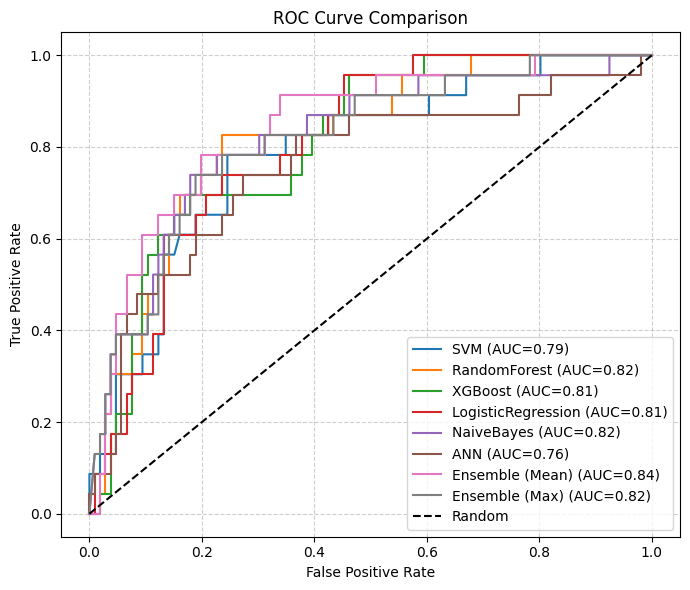

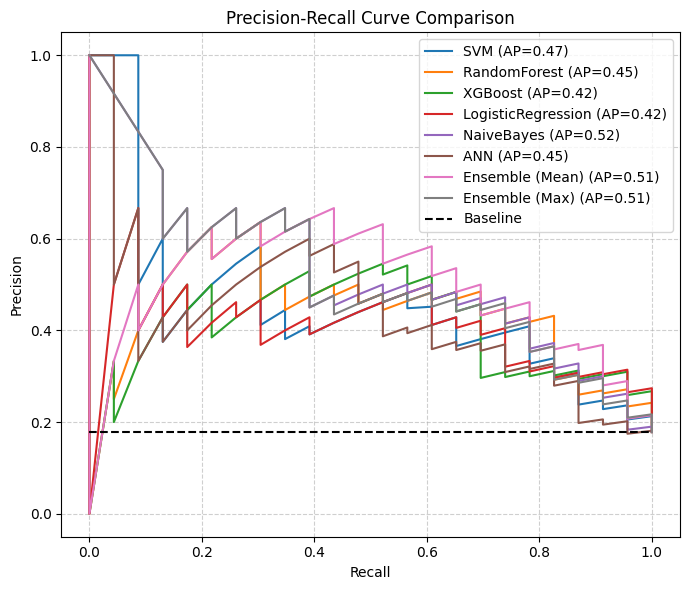

In [13]:
# ROC Curve (all models on one plot)
plt.figure(figsize=(7, 6))
for model_name, probs in val_probs.items():
    fpr, tpr, _ = roc_curve(y_val, probs)
    roc_auc = roc_auc_score(y_val, probs)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# PR Curve (all models on one plot)
plt.figure(figsize=(7, 6))
for model_name, probs in val_probs.items():
    precision, recall, _ = precision_recall_curve(y_val, probs)
    pr_auc = average_precision_score(y_val, probs)
    plt.plot(recall, precision, label=f"{model_name} (AP={pr_auc:.2f})")

baseline = np.mean(y_val)  # No-skill baseline
plt.hlines(baseline, 0, 1, colors='k', linestyles='--', label="Baseline")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

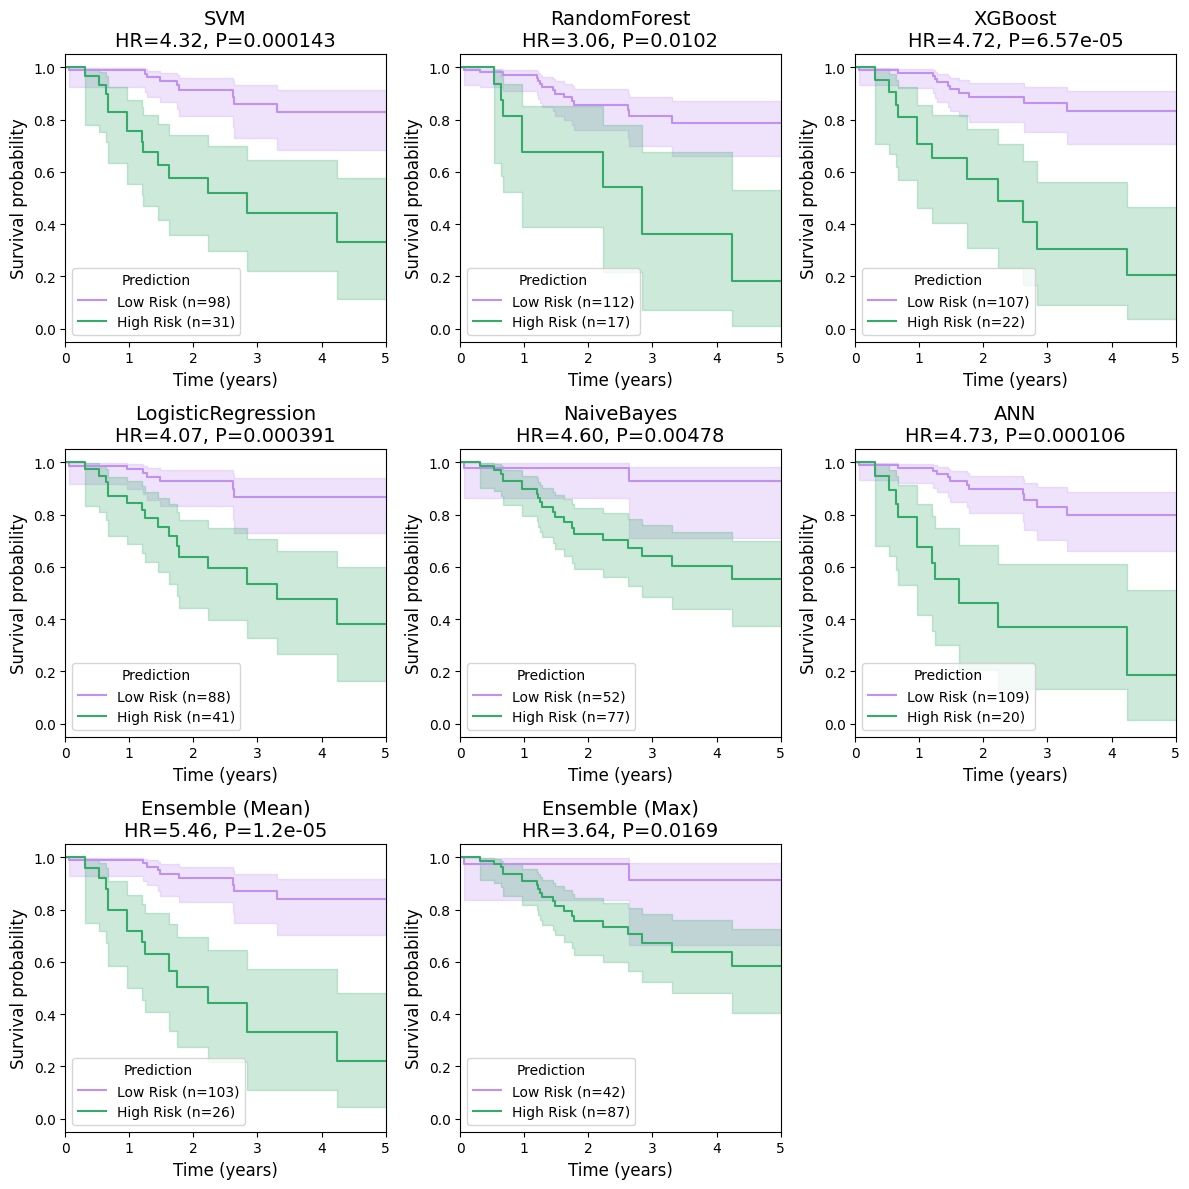

In [14]:
risk_labels = {0: "Low Risk", 1: "High Risk"}
model_list = ["SVM", "RandomForest", "XGBoost", "LogisticRegression", "NaiveBayes", "ANN", "Ensemble (Mean)", "Ensemble (Max)"]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()  # Flatten to 1D array for easy indexing

colours = ["#C190F0", "#35AB6A"]

for idx, model_choice in enumerate(model_list):
    ax = axes[idx]
    model_preds = (val_probs_df_full[model_choice] >= 0.5).astype(int)
    km_data = pd.DataFrame({
        "pred_class": model_preds,
        "DSS": dss_val["DSS"].values,
        "DSS_time": dss_val["DSS.time"].values
    })

    # Cox PH
    cox_df = km_data.rename(columns={"DSS_time": "time", "DSS": "event"})
    cph = CoxPHFitter()
    cph.fit(cox_df, duration_col="time", event_col="event")
    hr = np.exp(cph.params_["pred_class"])
    pval = cph.summary.loc["pred_class", "p"]

    # KM plots
    kmf = KaplanMeierFitter()
    for cls in [0, 1]:
        mask = km_data["pred_class"] == cls
        n_value = mask.sum()
        kmf.fit(
            durations=km_data.loc[mask, "DSS_time"] / 365,
            event_observed=km_data.loc[mask, "DSS"],
            label=f"{risk_labels[cls]} (n={n_value})"
        )
        kmf.plot_survival_function(ax=ax, ci_show=True, color=colours[cls])

    ax.set_title(f"{model_choice}\nHR={hr:.2f}, P={pval:.3g}", fontsize=14)
    ax.set_xlim(0, 5)
    ax.set_xlabel("Time (years)", fontsize=12)
    ax.set_ylabel("Survival probability", fontsize=12)
    ax.tick_params(axis="both", labelsize=10)
    ax.legend(fontsize=10, title="Prediction", title_fontsize=10, loc="lower left")

# Remove unused subplots if grid > number of models
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
